In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [4]:
query= text(r"SELECT DATE(datefrom) AS date, (regexp_split_to_array(layerid, '\|'))[2]  AS PRO_FROM, (regexp_split_to_array(toid, '\|'))[2]  AS PRO_TO, SUM(datavalue) AS datavalue FROM movements GROUP BY date, PRO_FROM, PRO_TO ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True) 
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

            date pro_from pro_to  datavalue
0     2019-08-01      033    033     367422
1     2019-08-01      033    034      29272
2     2019-08-01      033    035       4613
3     2019-08-01      033    036       3103
4     2019-08-01      033    037       5061
...          ...      ...    ...        ...
4936  2019-09-30      099    037       8017
4937  2019-09-30      099    038        531
4938  2019-09-30      099    039       7401
4939  2019-09-30      099    040      55041
4940  2019-09-30      099    099     487497

[4941 rows x 4 columns]


In [5]:
from sklearn.preprocessing import LabelEncoder
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["date"] = df['date'].astype('int64')
label_encoder = LabelEncoder()
df['pro_from'] = label_encoder.fit_transform(df['pro_from'])
df['pro_to'] = label_encoder.fit_transform(df['pro_to'])
df

,date,pro_from,pro_to,datavalue
0,1564617600000000000,0,0,367422
1,1564617600000000000,0,1,29272
2,1564617600000000000,0,2,4613
3,1564617600000000000,0,3,3103
4,1564617600000000000,0,4,5061
...,...,...,...,...
4936,1569801600000000000,8,4,8017
4937,1569801600000000000,8,5,531
4938,1569801600000000000,8,6,7401
4939,1569801600000000000,8,7,55041


In [6]:
X = df.drop(['datavalue'],axis='columns')
y = df['datavalue']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Random Forest

*** Random Forest ***
MAE = 13500.325643964936
MAPE = 40.32630407082969 %


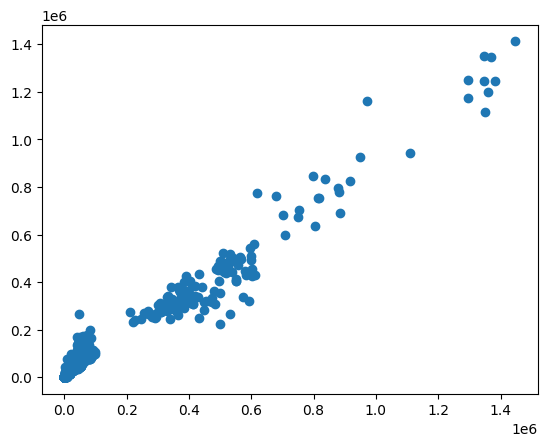

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print("*** Random Forest ***")
Model_RF = RandomForestRegressor()
Model_RF.fit(X_train, y_train)
y_pred_RF = Model_RF.predict(X_test)

print('MAE =', mean_absolute_error(y_test, y_pred_RF))
print('MAPE =', mean_absolute_percentage_error(y_test, y_pred_RF)*100 ,'%')
MAPE_RF = mean_absolute_percentage_error(y_test, y_pred_RF)*100
plt.scatter(y_test, y_pred_RF)
plt.show()

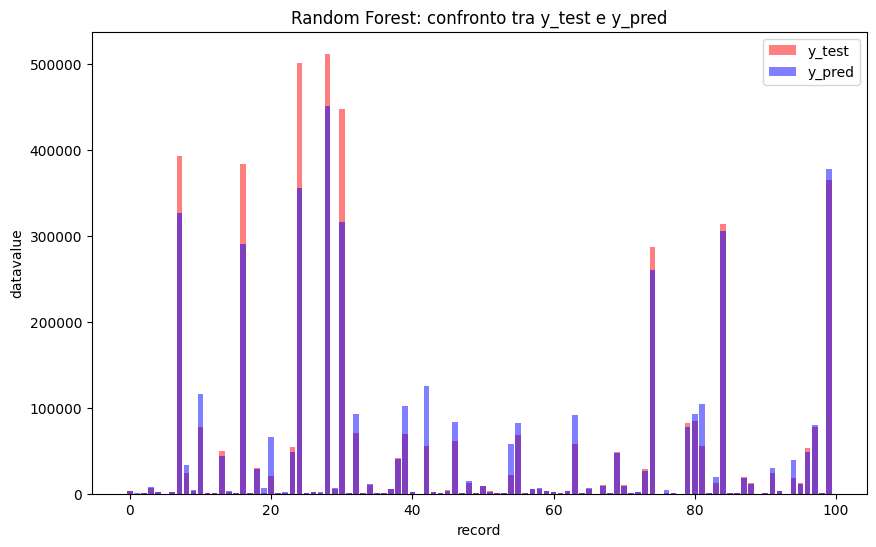

In [10]:
indici = np.arange(100)
plt.figure(figsize=(10, 6))
plt.bar(indici, y_test[:100], label='y_test', color='red', alpha = 0.5)
plt.bar(indici, y_pred_RF[:100], label='y_pred', color='blue', alpha = 0.5)
plt.xlabel('record')
plt.ylabel('datavalue')
plt.title('Random Forest: confronto tra y_test e y_pred')
plt.legend()
plt.show()

K-Nearest Neighbors

In [12]:
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [13]:
y_train_scaled_KNN = np.log1p(y_train)
y_test_scaled_KNN = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_KNN = scaler.fit_transform(X_train)
X_test_scaled_KNN = scaler.transform(X_test)

param_grid = {
    'n_neighbors': range(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train_scaled_KNN, y_train_scaled_KNN)
best_params = grid_search.best_params_
print("Migliori parametri:", best_params)

Migliori parametri: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}


*** K-Nearest Neighbors ***
MAE = 5007.091992305652
MAPE = 15.712369461613198 %


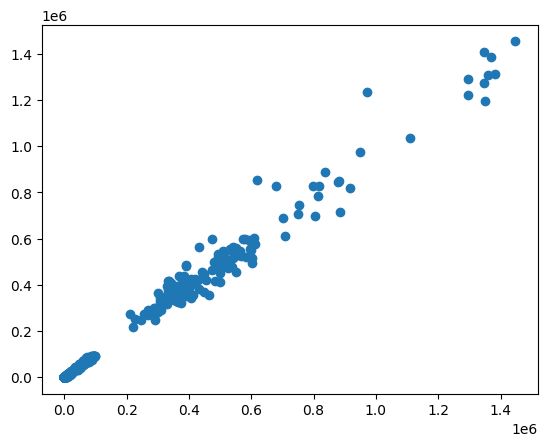

In [14]:
print("*** K-Nearest Neighbors ***")
Model_KNN = KNeighborsRegressor(
    n_neighbors= best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric']
)

Model_KNN.fit(X_train_scaled_KNN, y_train_scaled_KNN)
y_pred_KNN = Model_KNN.predict(X_test_scaled_KNN)

y_pred_KNN = np.expm1(y_pred_KNN)
y_test = np.expm1(y_test_scaled_KNN)

print('MAE =', mean_absolute_error(y_test, y_pred_KNN))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_KNN)*100,'%')
MAPE_KNN = mean_absolute_percentage_error(y_test, y_pred_KNN)*100
plt.scatter(y_test, y_pred_KNN)
plt.show()

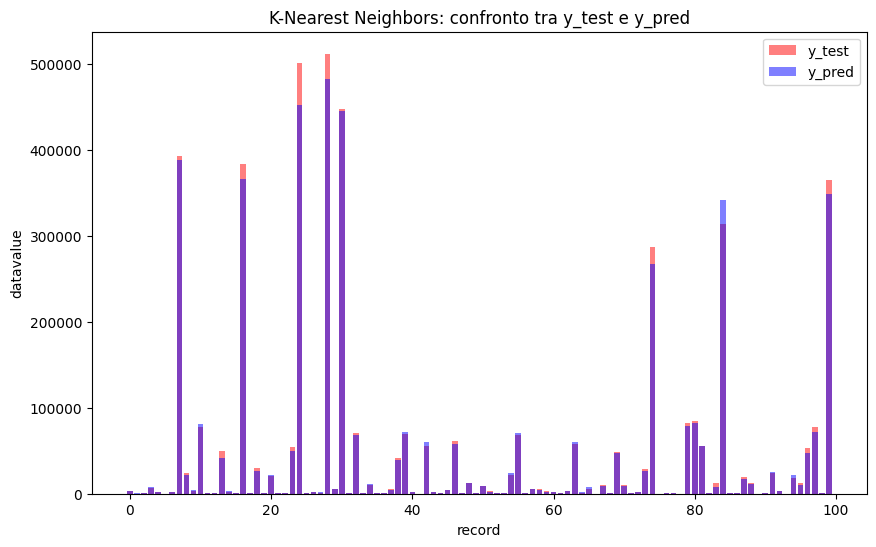

In [15]:
indici = np.arange(100)
plt.figure(figsize=(10, 6))
plt.bar(indici, y_test[:100], label='y_test', color='red', alpha = 0.5)
plt.bar(indici, y_pred_KNN[:100], label='y_pred', color='blue', alpha = 0.5)
plt.xlabel('record')
plt.ylabel('datavalue')
plt.title('K-Nearest Neighbors: confronto tra y_test e y_pred')
plt.legend()
plt.show()

Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

y_train_scaled_GB = np.log1p(y_train)
y_test_scaled_GB = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_GB = scaler.fit_transform(X_train)
X_test_scaled_GB = scaler.transform(X_test)

Model_GB = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [100, 300, 500],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 7]  
}

grid_search = GridSearchCV(estimator=Model_GB, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled_GB, y_train_scaled_GB)
print("Migliori parametri trovati:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Migliori parametri trovati: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}


*** Gradient Boosting ***
MAE = 5036.465264721239
MAPE = 10.595236611339816 %


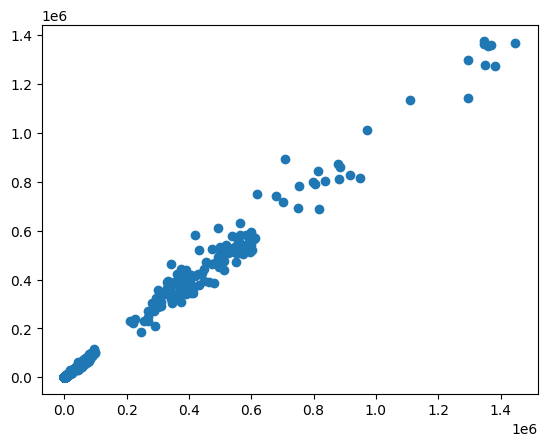

In [18]:
print("*** Gradient Boosting ***")
best_model = grid_search.best_estimator_
y_pred_GB = best_model.predict(X_test_scaled_GB)

y_pred_GB =np.expm1(y_pred_GB)
y_test =np.expm1(y_test_scaled_GB)
print('MAE =', mean_absolute_error(y_test, y_pred_GB))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_GB)*100,'%')
MAPE_GB = mean_absolute_percentage_error(y_test, y_pred_GB)*100
plt.scatter(y_test, y_pred_GB)
plt.show()

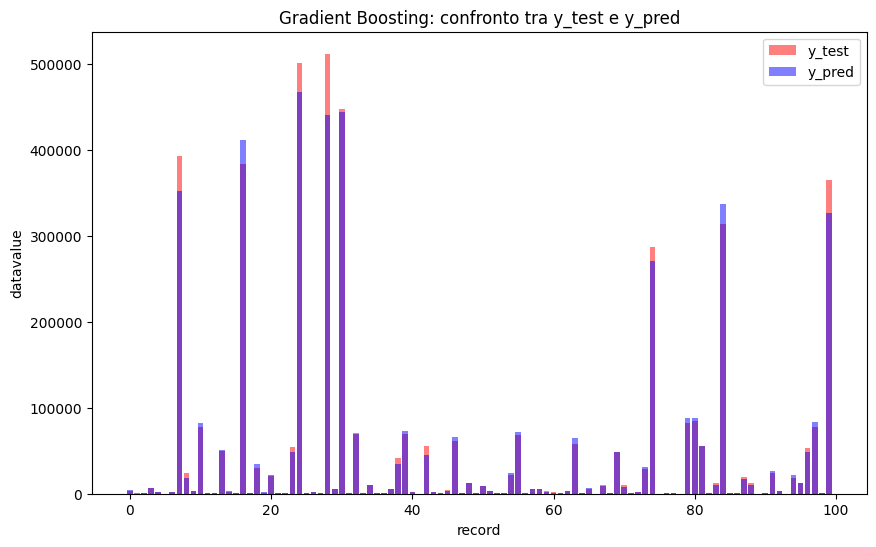

In [19]:
indici = np.arange(100)
plt.figure(figsize=(10, 6))
plt.bar(indici, y_test[:100], label='y_test', color='red', alpha = 0.5)
plt.bar(indici, y_pred_GB[:100], label='y_pred', color='blue', alpha = 0.5)
plt.xlabel('record')
plt.ylabel('datavalue')
plt.title('Gradient Boosting: confronto tra y_test e y_pred')
plt.legend()
plt.show()

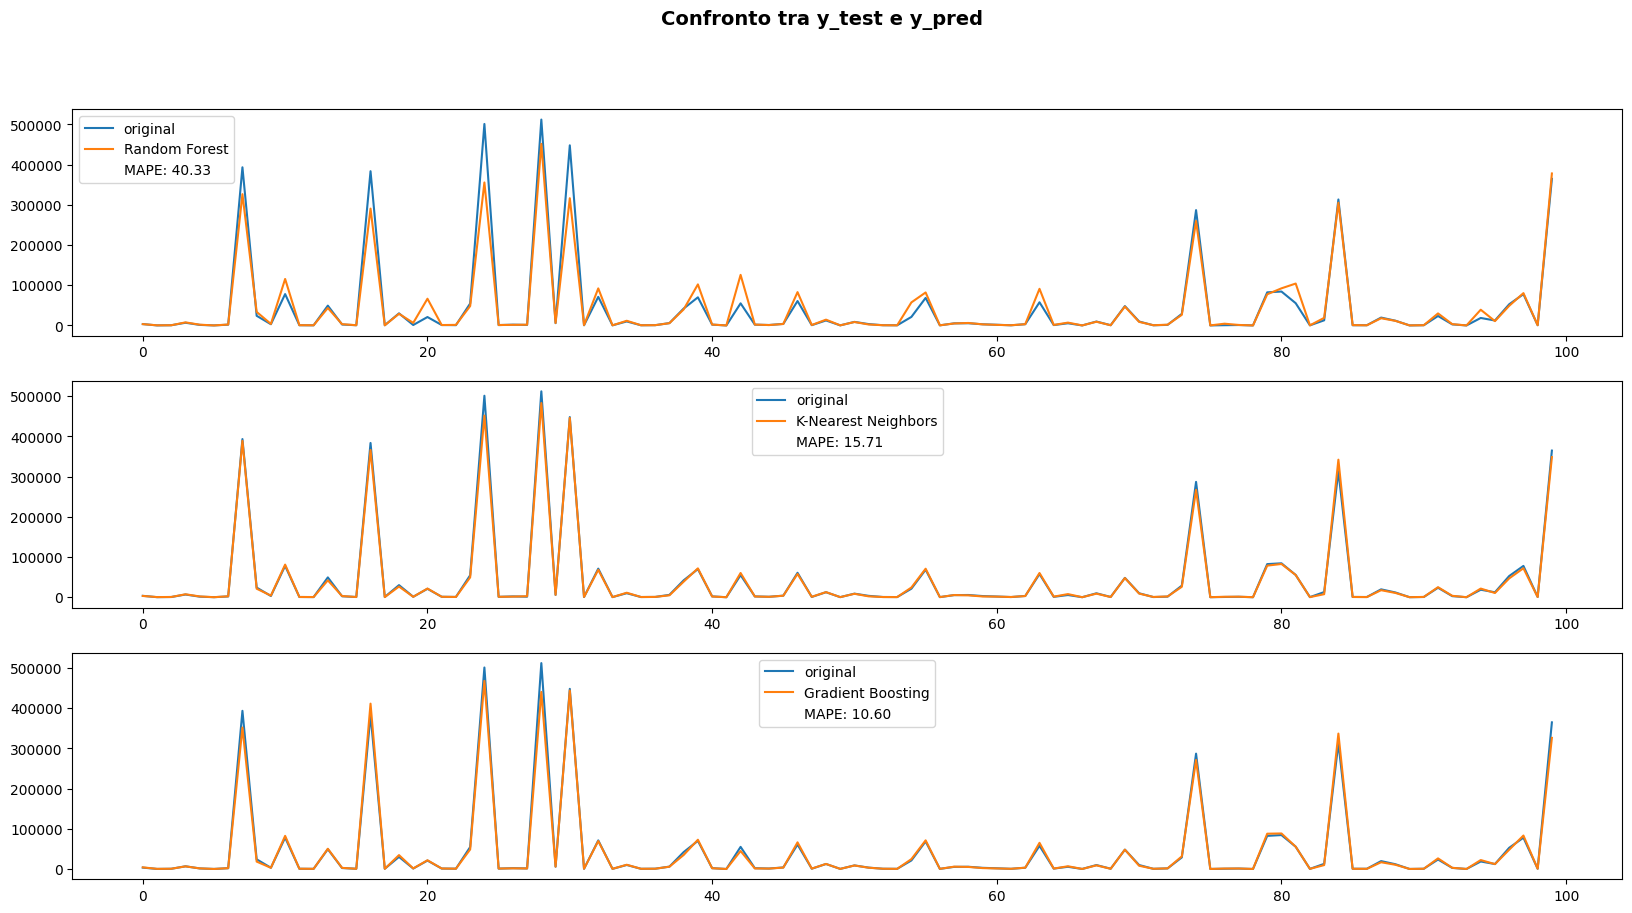

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10)) 
fig.suptitle('Confronto tra y_test e y_pred', fontsize=14, fontweight='bold')
axes[0].plot(indici, y_test[:100], label='original')
axes[0].plot(indici, y_pred_RF[:100],label='Random Forest')
axes[0].legend()
axes[0].plot([], [], ' ', label=f'MAPE: {MAPE_RF:.2f}')
axes[0].legend()
axes[1].plot(indici, y_test[:100], label='original')
axes[1].plot(indici, y_pred_KNN[:100],label='K-Nearest Neighbors')
axes[1].plot([], [], ' ', label=f'MAPE: {MAPE_KNN:.2f}')
axes[1].legend()
axes[2].plot(indici, y_test[:100], label='original')
axes[2].plot(indici, y_pred_GB[:100],label='Gradient Boosting')
axes[2].plot([], [], ' ', label=f'MAPE: {MAPE_GB:.2f}')
axes[2].legend()
plt.show()